# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../logs/comick/79_contexts/10-11-2022_19-39-04/oov_embedding_dict.pkl", "rb"))
oov_embeddings = {key: embeddings["<UNK>"] for key, _ in oov_embeddings.items()}

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4907 | MulticlassF1Score=0.1409
Batch-30 : CrossEntropyLoss=2.4790 | MulticlassF1Score=0.1829
Batch-45 : CrossEntropyLoss=2.4495 | MulticlassF1Score=0.2016
Batch-60 : CrossEntropyLoss=2.4094 | MulticlassF1Score=0.2367
Batch-75 : CrossEntropyLoss=2.4068 | MulticlassF1Score=0.2813
Batch-90 : CrossEntropyLoss=2.3717 | MulticlassF1Score=0.3253
Batch-105: CrossEntropyLoss=2.3849 | MulticlassF1Score=0.3598
Batch-120: CrossEntropyLoss=2.3570 | MulticlassF1Score=0.3909
Batch-135: CrossEntropyLoss=2.3631 | MulticlassF1Score=0.4204
Batch-150: CrossEntropyLoss=2.3523 | MulticlassF1Score=0.4426
Batch-165: CrossEntropyLoss=2.3617 | MulticlassF1Score=0.4605
Batch-180: CrossEntropyLoss=2.3708 | MulticlassF1Score=0.4766
Batch-195: CrossEntropyLoss=2.3470 | MulticlassF1Score=0.4925
Batch-210: CrossEntropyLoss=2.3384 | MulticlassF1Score=0.5062
Batch-225: CrossEntropyLoss=2.3330 | MulticlassF1Score=0.5217
Batch-226: CrossEntropyLoss=2.3325 | MulticlassF1Score=0.5224

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3326 | MulticlassF1Score=0.7388
Batch-30 : CrossEntropyLoss=2.3310 | MulticlassF1Score=0.7373
Batch-45 : CrossEntropyLoss=2.3312 | MulticlassF1Score=0.7388
Batch-60 : CrossEntropyLoss=2.3393 | MulticlassF1Score=0.7393
Batch-63 : CrossEntropyLoss=2.3246 | MulticlassF1Score=0.7391

Training   : Mean CrossEntropyLoss = 2.4072 | Mean MulticlassF1Score = 0.3513
Validation : Mean CrossEntropyLoss = 2.3301 | Mean MulticlassF1Score = 0.7393

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3259 | MulticlassF1Score=0.7316
Batch-30 : CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7441
Batch-45 : CrossEntropyLoss=2.3356 | MulticlassF1Score=0.7451
Batch-60 : CrossEntropyLoss=2.3337 | MulticlassF1Score=0.7490
Batch-75 : CrossEntropyLoss=2.3274 | MulticlassF1Score=0.7524
Batch-90 : CrossEntropyLoss=2.3235 | MulticlassF1Score=0.7548
Batch-105: CrossEntropyLoss=2.3247 | MulticlassF1Score=0.7561
Batch-120: CrossEntropyLoss=2.3212 | MulticlassF1Score=0.7576
Batch-135: CrossEntropyLoss=2.3299 | MulticlassF1Score=0.7588
Batch-150: CrossEntropyLoss=2.3160 | MulticlassF1Score=0.7606
Batch-165: CrossEntropyLoss=2.3159 | MulticlassF1Score=0.7616
Batch-180: CrossEntropyLoss=2.3229 | MulticlassF1Score=0.7622
Batch-195: CrossEntropyLoss=2.3187 | MulticlassF1Score=0.7627
Batch-210: CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7634
Batch-225: CrossEntropyLoss=2.3171 | MulticlassF1Score=0.7635
Batch-226: CrossEntropyLoss=2.3271 | MulticlassF1Score=0.7634

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3251 | MulticlassF1Score=0.7674
Batch-30 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7679
Batch-45 : CrossEntropyLoss=2.3244 | MulticlassF1Score=0.7689
Batch-60 : CrossEntropyLoss=2.3328 | MulticlassF1Score=0.7692
Batch-63 : CrossEntropyLoss=2.3312 | MulticlassF1Score=0.7698

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3219 | Mean MulticlassF1Score = 0.7542
Validation : Mean CrossEntropyLoss = 2.3192 | Mean MulticlassF1Score = 0.7691

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3175 | MulticlassF1Score=0.7722
Batch-30 : CrossEntropyLoss=2.3190 | MulticlassF1Score=0.7734
Batch-45 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.7701
Batch-60 : CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7707
Batch-75 : CrossEntropyLoss=2.3168 | MulticlassF1Score=0.7700
Batch-90 : CrossEntropyLoss=2.3223 | MulticlassF1Score=0.7688
Batch-105: CrossEntropyLoss=2.3277 | MulticlassF1Score=0.7689
Batch-120: CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7696
Batch-135: CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7702
Batch-150: CrossEntropyLoss=2.3181 | MulticlassF1Score=0.7714
Batch-165: CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7716
Batch-180: CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7729
Batch-195: CrossEntropyLoss=2.3195 | MulticlassF1Score=0.7743
Batch-210: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7751
Batch-225: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.7767
Batch-226: CrossEntropyLoss=2.3181 | MulticlassF1Score=0.7768

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3143 | MulticlassF1Score=0.7890
Batch-30 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.7893
Batch-45 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.7896
Batch-60 : CrossEntropyLoss=2.3153 | MulticlassF1Score=0.7905
Batch-63 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7906

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3172 | Mean MulticlassF1Score = 0.7715
Validation : Mean CrossEntropyLoss = 2.3127 | Mean MulticlassF1Score = 0.7897

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7963
Batch-30 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8000
Batch-45 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8003
Batch-60 : CrossEntropyLoss=2.3189 | MulticlassF1Score=0.8005
Batch-75 : CrossEntropyLoss=2.3131 | MulticlassF1Score=0.8017
Batch-90 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8020
Batch-105: CrossEntropyLoss=2.3156 | MulticlassF1Score=0.8040
Batch-120: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8049
Batch-135: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8068
Batch-150: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8076
Batch-165: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8086
Batch-180: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.8090
Batch-195: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8093
Batch-210: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8097
Batch-225: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8098
Batch-226: CrossEntropyLoss=2.3158 | MulticlassF1Score=0.8097

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8185
Batch-30 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8166
Batch-45 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8168
Batch-60 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8156
Batch-63 : CrossEntropyLoss=2.3149 | MulticlassF1Score=0.8153

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3070 | Mean MulticlassF1Score = 0.8040
Validation : Mean CrossEntropyLoss = 2.3050 | Mean MulticlassF1Score = 0.8165

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8157
Batch-30 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8211
Batch-45 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8194
Batch-60 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8179
Batch-75 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8188
Batch-90 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8182
Batch-105: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8189
Batch-120: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8192
Batch-135: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8188
Batch-150: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8189
Batch-165: CrossEntropyLoss=2.3149 | MulticlassF1Score=0.8186
Batch-180: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8192
Batch-195: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8199
Batch-210: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8213
Batch-225: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8225
Batch-226: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8226

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8412
Batch-30 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8382
Batch-45 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8401
Batch-60 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8414
Batch-63 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8411

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3029 | Mean MulticlassF1Score = 0.8190
Validation : Mean CrossEntropyLoss = 2.2974 | Mean MulticlassF1Score = 0.8406

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8466
Batch-30 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8467
Batch-45 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8465
Batch-60 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8455
Batch-75 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8447
Batch-90 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8448
Batch-105: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8446
Batch-120: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8443
Batch-135: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8453
Batch-150: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8453
Batch-165: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8450
Batch-180: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8448
Batch-195: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8450
Batch-210: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8453
Batch-225: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8456
Batch-226: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8455

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8373
Batch-30 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8419
Batch-45 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8438
Batch-60 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8448
Batch-63 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8440

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2959 | Mean MulticlassF1Score = 0.8452
Validation : Mean CrossEntropyLoss = 2.2962 | Mean MulticlassF1Score = 0.8425

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8509
Batch-30 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8494
Batch-45 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8490
Batch-60 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8497
Batch-75 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8515
Batch-90 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8539
Batch-105: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8557
Batch-120: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8581
Batch-135: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8590
Batch-150: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8603
Batch-165: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8621
Batch-180: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8632
Batch-195: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8642
Batch-210: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8653
Batch-225: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8655
Batch-226: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8654

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8726
Batch-30 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8718
Batch-45 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8732
Batch-60 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8716
Batch-63 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8716

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2898 | Mean MulticlassF1Score = 0.8566
Validation : Mean CrossEntropyLoss = 2.2876 | Mean MulticlassF1Score = 0.8721

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8760
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8779
Batch-45 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8808
Batch-60 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8794
Batch-75 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8800
Batch-90 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8816
Batch-105: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8818
Batch-120: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8815
Batch-135: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8814
Batch-150: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8811
Batch-165: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8807
Batch-180: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8808
Batch-195: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8804
Batch-210: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8803
Batch-225: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8803
Batch-226: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8802

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8795
Batch-30 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8755
Batch-45 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8741
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8746
Batch-63 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8749

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2852 | Mean MulticlassF1Score = 0.8804
Validation : Mean CrossEntropyLoss = 2.2866 | Mean MulticlassF1Score = 0.8771

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8802
Batch-30 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8849
Batch-45 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8842
Batch-60 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8839
Batch-75 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8845
Batch-90 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8850
Batch-105: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8850
Batch-120: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8856
Batch-135: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8853
Batch-150: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8851
Batch-165: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8852
Batch-180: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8849
Batch-195: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8847
Batch-210: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8847
Batch-225: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8848
Batch-226: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8847

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8766
Batch-30 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8781
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8764
Batch-60 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8767
Batch-63 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8767

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2837 | Mean MulticlassF1Score = 0.8841
Validation : Mean CrossEntropyLoss = 2.2860 | Mean MulticlassF1Score = 0.8767

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8859
Batch-30 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8830
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8860
Batch-60 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8867
Batch-75 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8880
Batch-90 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8870
Batch-105: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8879
Batch-120: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8881
Batch-135: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8870
Batch-150: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8869
Batch-165: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8870
Batch-180: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8870
Batch-195: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8867
Batch-210: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8867
Batch-225: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8867
Batch-226: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8867

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8742
Batch-30 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8775
Batch-45 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8777
Batch-60 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8765
Batch-63 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8767

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8867
Validation : Mean CrossEntropyLoss = 2.2859 | Mean MulticlassF1Score = 0.8768

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8891
Batch-30 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8862
Batch-45 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8856
Batch-60 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8865
Batch-75 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8880
Batch-90 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8882
Batch-105: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8884
Batch-120: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8886
Batch-135: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8884
Batch-150: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8888
Batch-165: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8888
Batch-180: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8886
Batch-195: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8888
Batch-210: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8889
Batch-225: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8887
Batch-226: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8887

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8776
Batch-30 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8764
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8741
Batch-60 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8761
Batch-63 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8767

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2822 | Mean MulticlassF1Score = 0.8882
Validation : Mean CrossEntropyLoss = 2.2857 | Mean MulticlassF1Score = 0.8784

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8915
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8889
Batch-45 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8897
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8898
Batch-75 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8895
Batch-90 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8900
Batch-105: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8901
Batch-120: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8900
Batch-135: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8901
Batch-150: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8903
Batch-165: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8905
Batch-180: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8904
Batch-195: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8905
Batch-210: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8905
Batch-225: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8905
Batch-226: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8905

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8797
Batch-30 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8817
Batch-45 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8796
Batch-60 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8781
Batch-63 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8775

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8901
Validation : Mean CrossEntropyLoss = 2.2855 | Mean MulticlassF1Score = 0.8811

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8899
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8931
Batch-45 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8922
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8932
Batch-75 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8924
Batch-90 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8925
Batch-105: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8924
Batch-120: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8939
Batch-135: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8960
Batch-150: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8974
Batch-165: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.8991
Batch-180: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9007
Batch-195: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9013
Batch-210: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9024
Batch-225: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9032
Batch-226: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9032

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9030
Batch-30 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9045
Batch-45 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9047
Batch-60 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9045
Batch-63 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9048

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.8954
Validation : Mean CrossEntropyLoss = 2.2773 | Mean MulticlassF1Score = 0.9040

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9219
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9223
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9225
Batch-75 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9224
Batch-90 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9225
Batch-105: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9230
Batch-120: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9234
Batch-135: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9232
Batch-150: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9228
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9230
Batch-180: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9231
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9230
Batch-210: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9228
Batch-225: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9229
Batch-226: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9229

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9102
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9114
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9088
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9095
Batch-63 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9095

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9232
Validation : Mean CrossEntropyLoss = 2.2758 | Mean MulticlassF1Score = 0.9090

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9253
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9239
Batch-75 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9249
Batch-90 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9251
Batch-105: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9249
Batch-120: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9248
Batch-135: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9252
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9252
Batch-165: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9252
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9253
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9257
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9259
Batch-225: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9258
Batch-226: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9258

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9141
Batch-30 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9132
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9120
Batch-60 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9120
Batch-63 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9121

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9252
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9128

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9267
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9267
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9272
Batch-75 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9278
Batch-90 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9282
Batch-105: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9284
Batch-120: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9284
Batch-135: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9286
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9289
Batch-165: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9286
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9283
Batch-195: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9285
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9286
Batch-225: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9286
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9286

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9100
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9118
Batch-45 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9116
Batch-60 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9109
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9110

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9280
Validation : Mean CrossEntropyLoss = 2.2751 | Mean MulticlassF1Score = 0.9109

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9285
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9285
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9276
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9283
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9286
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9293
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9302
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9302
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9305
Batch-165: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9312
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9315
Batch-195: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9310
Batch-210: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9315
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9315
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9315

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9177
Batch-30 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9139
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9145
Batch-60 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9146
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9150

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9297
Validation : Mean CrossEntropyLoss = 2.2740 | Mean MulticlassF1Score = 0.9155

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9359
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9351
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9349
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9342
Batch-75 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9345
Batch-90 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9348
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9355
Batch-120: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9346
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9346
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9342
Batch-165: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9337
Batch-180: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9337
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9339
Batch-210: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9338
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9337
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9338

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9161
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9172
Batch-45 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9156
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9154
Batch-63 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9152

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9347
Validation : Mean CrossEntropyLoss = 2.2739 | Mean MulticlassF1Score = 0.9156

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9340
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9373
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9363
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9358
Batch-75 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9355
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9353
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9358
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9354
Batch-135: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9354
Batch-150: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9355
Batch-165: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9355
Batch-180: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9351
Batch-195: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9350
Batch-210: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9350
Batch-225: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9351
Batch-226: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9350

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9184
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9135
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9135
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9149
Batch-63 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9149

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2677 | Mean MulticlassF1Score = 0.9354
Validation : Mean CrossEntropyLoss = 2.2739 | Mean MulticlassF1Score = 0.9145

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9352
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9357
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9358
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9358
Batch-75 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9364
Batch-90 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9361
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9364
Batch-120: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9363
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9364
Batch-150: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9364
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9359
Batch-180: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9355
Batch-195: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9353
Batch-210: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9353
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9356
Batch-226: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9356

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9129
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9138
Batch-45 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.9139
Batch-60 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9145
Batch-63 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9142

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9357
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9148

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9338
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9372
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9369
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9353
Batch-75 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9364
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9367
Batch-105: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9364
Batch-120: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9363
Batch-135: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9358
Batch-150: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9360
Batch-165: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9359
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9357
Batch-195: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9361
Batch-210: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9362
Batch-225: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9361
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9362

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9137
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9157
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9161
Batch-60 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9150
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9149

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9361
Validation : Mean CrossEntropyLoss = 2.2740 | Mean MulticlassF1Score = 0.9160

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9362
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9359
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9365
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9361
Batch-75 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9363
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9362
Batch-105: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9359
Batch-120: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9366
Batch-135: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9366
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9368
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9369
Batch-180: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9369
Batch-195: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9374
Batch-210: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9372
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9370
Batch-226: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9370

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9134
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9176
Batch-45 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9157
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9154
Batch-63 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9157

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9365
Validation : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9154

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9388
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9375
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9382
Batch-75 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9380
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9381
Batch-105: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9379
Batch-120: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9380
Batch-135: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9381
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9378
Batch-165: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9378
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9377
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9377
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9376
Batch-225: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9377

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9116
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9127
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9135
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9153
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9154

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9381
Validation : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9126

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9392
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9385
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9382
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9377
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9377
Batch-90 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9378
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9378
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9380
Batch-135: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9377
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9379
Batch-165: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9381
Batch-180: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9380
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9382
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9381
Batch-225: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9379
Batch-226: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9379

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9141
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9145
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9155
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9151
Batch-63 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9151

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9382
Validation : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9142

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9378
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9384
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9384
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9381
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9385
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9388
Batch-105: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9390
Batch-120: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9393
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9396
Batch-150: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9393
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9390
Batch-180: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9389
Batch-195: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9388
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9384
Batch-225: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9381
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9381

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9181
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9164
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9154
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9158
Batch-63 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9151

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9386
Validation : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9173

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9401
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9386
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9389
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9389
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9388
Batch-90 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9386
Batch-105: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9387
Batch-120: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9388
Batch-135: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9390
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9387
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9383
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9385
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9384
Batch-210: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9382
Batch-225: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9380
Batch-226: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9380

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9181
Batch-30 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9164
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9145
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9152
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9146

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9389
Validation : Mean CrossEntropyLoss = 2.2739 | Mean MulticlassF1Score = 0.9166
Patience = 1/50❗

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9389
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9383
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9380
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9386
Batch-90 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9390
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9389
Batch-120: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9390
Batch-135: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9391
Batch-150: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9391
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9388
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9386
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9388
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9389
Batch-225: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9389
Batch-226: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9388

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9179
Batch-30 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9137
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9144
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9152
Batch-63 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9153

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9391
Validation : Mean CrossEntropyLoss = 2.2736 | Mean MulticlassF1Score = 0.9144

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9390
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9416
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9396
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9397
Batch-90 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9392
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9397
Batch-120: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9398
Batch-135: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9399
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9400
Batch-165: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9399
Batch-180: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9400
Batch-195: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9400
Batch-210: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9403
Batch-225: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9404
Batch-226: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9405

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9181
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9166
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9169
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9168
Batch-63 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.9165

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9400
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9168

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9365
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9400
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9411
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9413
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9415
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9416
Batch-120: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9419
Batch-135: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9410
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9411
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9413
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9416
Batch-195: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9416
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9415
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9413
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9413

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9191
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9187
Batch-45 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9171
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9174
Batch-63 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9175

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9409
Validation : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9191

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9440
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9421
Batch-75 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9421
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9421
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9421
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9424
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9421
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9420
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9423
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9419
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9416
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9417
Batch-225: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9417
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9417

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9151
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9160
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9169
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9171
Batch-63 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9170

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9429
Validation : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9166

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9411
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9396
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9401
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9406
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9417
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9418
Batch-135: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9420
Batch-150: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9420
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9422
Batch-180: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9421
Batch-195: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9422
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9421
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9418
Batch-226: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9418

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9165
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9201
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9181
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9168
Batch-63 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9168

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9416
Validation : Mean CrossEntropyLoss = 2.2733 | Mean MulticlassF1Score = 0.9180

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9434
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9426
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9424
Batch-90 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9418
Batch-105: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9414
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9413
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9413
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9416
Batch-165: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9419
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9419
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9419
Batch-210: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9420
Batch-225: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9420
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9419

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9190
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9162
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9167
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9164
Batch-63 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9170

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9420
Validation : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9179

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9426
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9427
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9430
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9430
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9432
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9436
Batch-120: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9433
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9429
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9432
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9431
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9429
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9427
Batch-225: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9427
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9427

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9197
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9185
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9187
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9185
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9181

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9430
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9193

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9424
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9430
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9429
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9435
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9433
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9433
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9430
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9429
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9428
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9429
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9431
Batch-225: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9429
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9126
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9166
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9174
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9177
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9178

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9169

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9438
Batch-75 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9430
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9433
Batch-105: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9429
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9428
Batch-135: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9427
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9427
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9430
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9432
Batch-195: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9434
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9435
Batch-226: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9435

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9191
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9169
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9187
Batch-60 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9182
Batch-63 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9182

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9435
Validation : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9184

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9449
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9450
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9448
Batch-105: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9448
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9447
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9442
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9440
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9439
Batch-180: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9437
Batch-195: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9437
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9437
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9438
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9438

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9186
Batch-30 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9175
Batch-45 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9181
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9182
Batch-63 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9180

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9441
Validation : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9179

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9462
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9450
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9450
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9450
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9449
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9450
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9445
Batch-180: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9441
Batch-195: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9440
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9441
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9441
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9148
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9165
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9164
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9177
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9182

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9453
Validation : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9153

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9459
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9460
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9459
Batch-105: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9459
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9456
Batch-135: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9453
Batch-165: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9447
Batch-180: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9444
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9454
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9461
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9472
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9473

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9359
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9362
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9355
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9360
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9358

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9364

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9635
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9641
Batch-45 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9643
Batch-60 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9640
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9641
Batch-90 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9641
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9637
Batch-120: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9638
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9638
Batch-150: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9637
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9639
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9638
Batch-195: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9636
Batch-210: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9638
Batch-225: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9638
Batch-226: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9638

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9354
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9329
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9361
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9369
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9366

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9640
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9348

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9645
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9655
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9650
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9646
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9655
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9651
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9650
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9648
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9646
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9648
Batch-165: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9649
Batch-180: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9646
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9647
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9647
Batch-225: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9648
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9648

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9350
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9379
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9370
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9371
Batch-63 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9368

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9649
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9367

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9654
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9649
Batch-45 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9656
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9653
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9654
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9655
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9653
Batch-120: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9651
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9648
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9645
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9645
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9645
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9646
Batch-210: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9645
Batch-225: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9644
Batch-226: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9644

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9347
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9355
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9362
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9364
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9366

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9649
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9357
Patience = 2/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9630
Batch-30 : CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9630
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9636
Batch-60 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9642
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9641
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9644
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9644
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9642
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9645
Batch-150: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9642
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9642
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9642
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9645
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9646
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9645
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9645

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9362
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9356
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9375
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9379
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9375

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9641
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9360

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9650
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9652
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9653
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9654
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9652
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9651
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9654
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9655
Batch-135: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9651
Batch-150: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9653
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9654
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9655
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9653
Batch-210: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9653
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9651
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9651

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9350
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9361
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9370
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9371

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9653
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9364

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9670
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9654
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9654
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9656
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9653
Batch-105: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9653
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9654
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9652
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9651
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9652
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9652
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9654
Batch-210: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9655
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9653
Batch-226: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9654

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9386
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9381
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9374
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9382
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9384

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9658
Validation : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9383

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9651
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9657
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9663
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9666
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9659
Batch-90 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9657
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9657
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9654
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9655
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9655
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9656
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9657
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9656
Batch-210: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9654
Batch-225: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9655
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9655

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9365
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9364
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9369
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9371
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9375

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9658
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9361

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9659
Batch-30 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9668
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9669
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9666
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9666
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9663
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9659
Batch-120: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9659
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9656
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9656
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9656
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9655
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9657
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9658
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9657
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9367
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9356
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9361
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9378
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9377

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9661
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9357

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9660
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9665
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9660
Batch-75 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9664
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9662
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9659
Batch-120: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9656
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9654
Batch-150: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9657
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9659
Batch-180: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9659
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9659
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9657
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9658

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9383
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9386
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9385
Batch-63 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9386

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9660
Validation : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9396

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9653
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9643
Batch-45 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9652
Batch-60 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9663
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9662
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9660
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9661
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9662
Batch-150: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9651
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9639
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9626
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9618
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9612
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9609
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9609

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9342
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9346
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9338
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9343
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9339

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2597 | Mean MulticlassF1Score = 0.9644
Validation : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9347
Patience = 3/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9576
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9580
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9576
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9577
Batch-75 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9576
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9571
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9568
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9573
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9571
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9573
Batch-165: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9576
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9577
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9579
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9577
Batch-225: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9576
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9576

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9381
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9364
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9372
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9361
Batch-63 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9364

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2607 | Mean MulticlassF1Score = 0.9575
Validation : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9364
Patience = 4/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9589
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9603
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9605
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9619
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9618
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9621
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9618
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9618
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9620
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9619
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9620
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9615
Batch-195: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9617
Batch-210: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9617
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9615
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9615

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9348
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9351
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9368
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9364
Batch-63 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9362

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2595 | Mean MulticlassF1Score = 0.9614
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9353

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2595
Best CrossEntropyLoss training    : 2.2672
Best MulticlassF1Score validation : 0.9614
Best MulticlassF1Score validation : 0.9353
Training duration                 : 1.9632 minutes.
Training date                     : 2022-10-24 18:58:16.616325+08:00


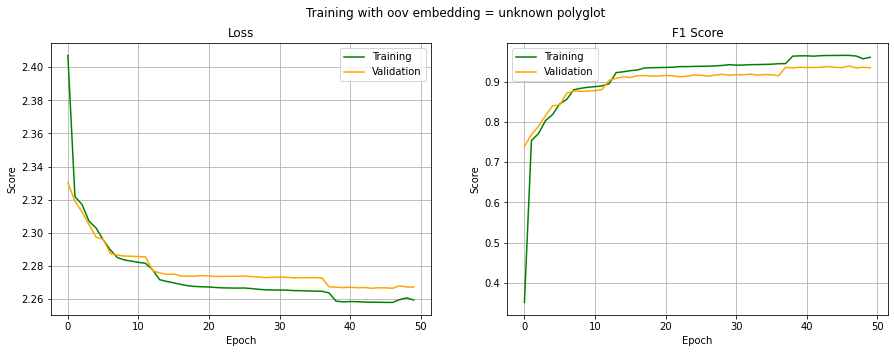

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../logs/unk/fold_{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with oov embedding = unknown polyglot")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9638, device='cuda:0'),
 tensor(0.9362, device='cuda:0'),
 tensor(0.9382, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9638, device='cuda:0'),
 tensor(0.9362, device='cuda:0'),
 tensor(0.9382, device='cuda:0'))

## Heatmap

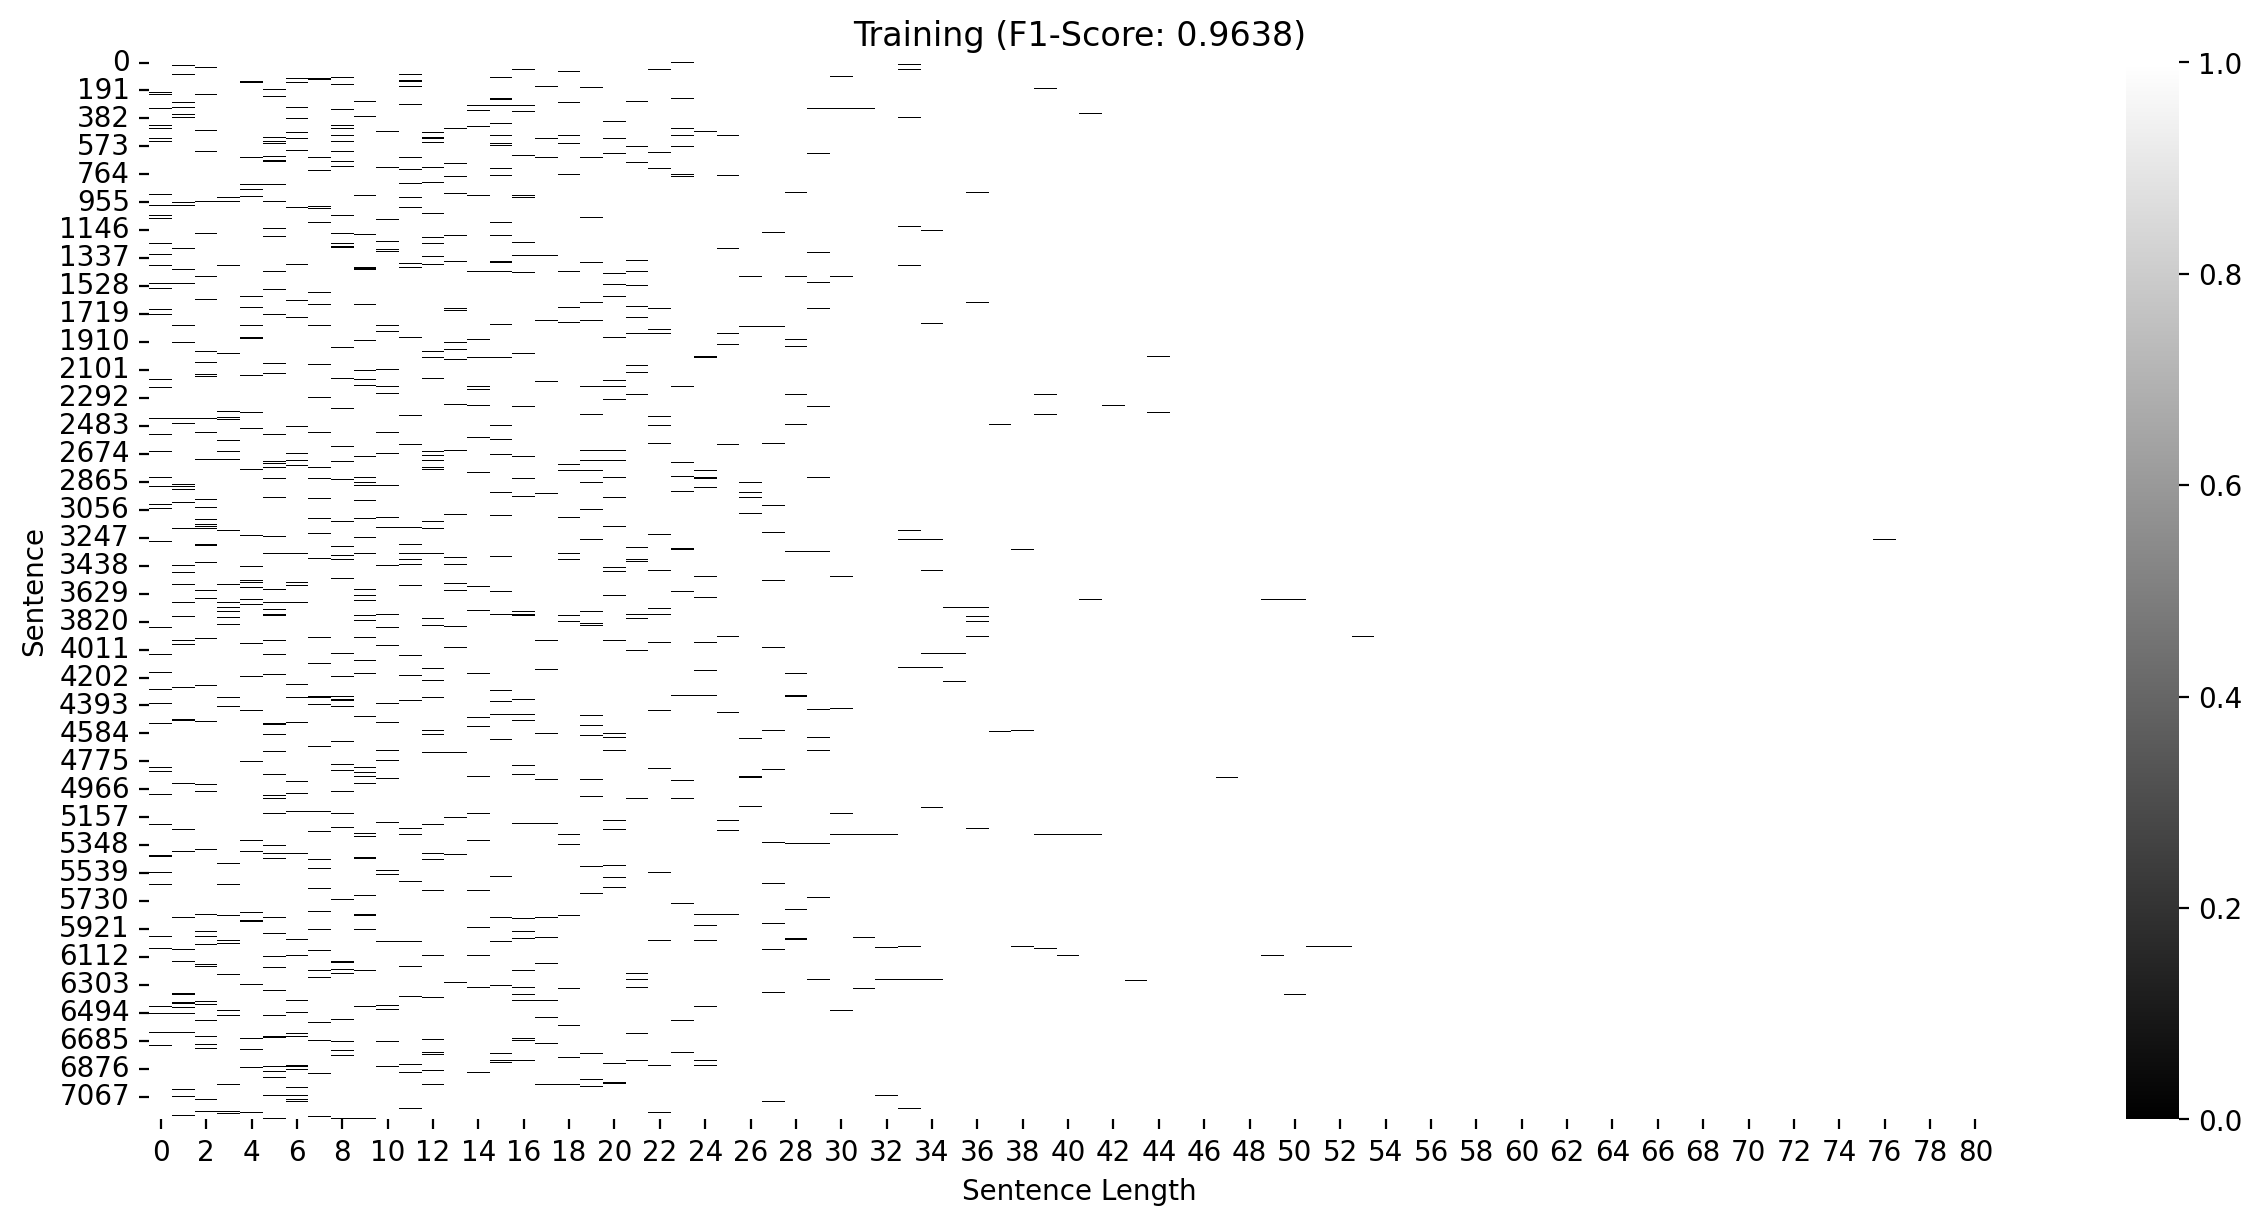

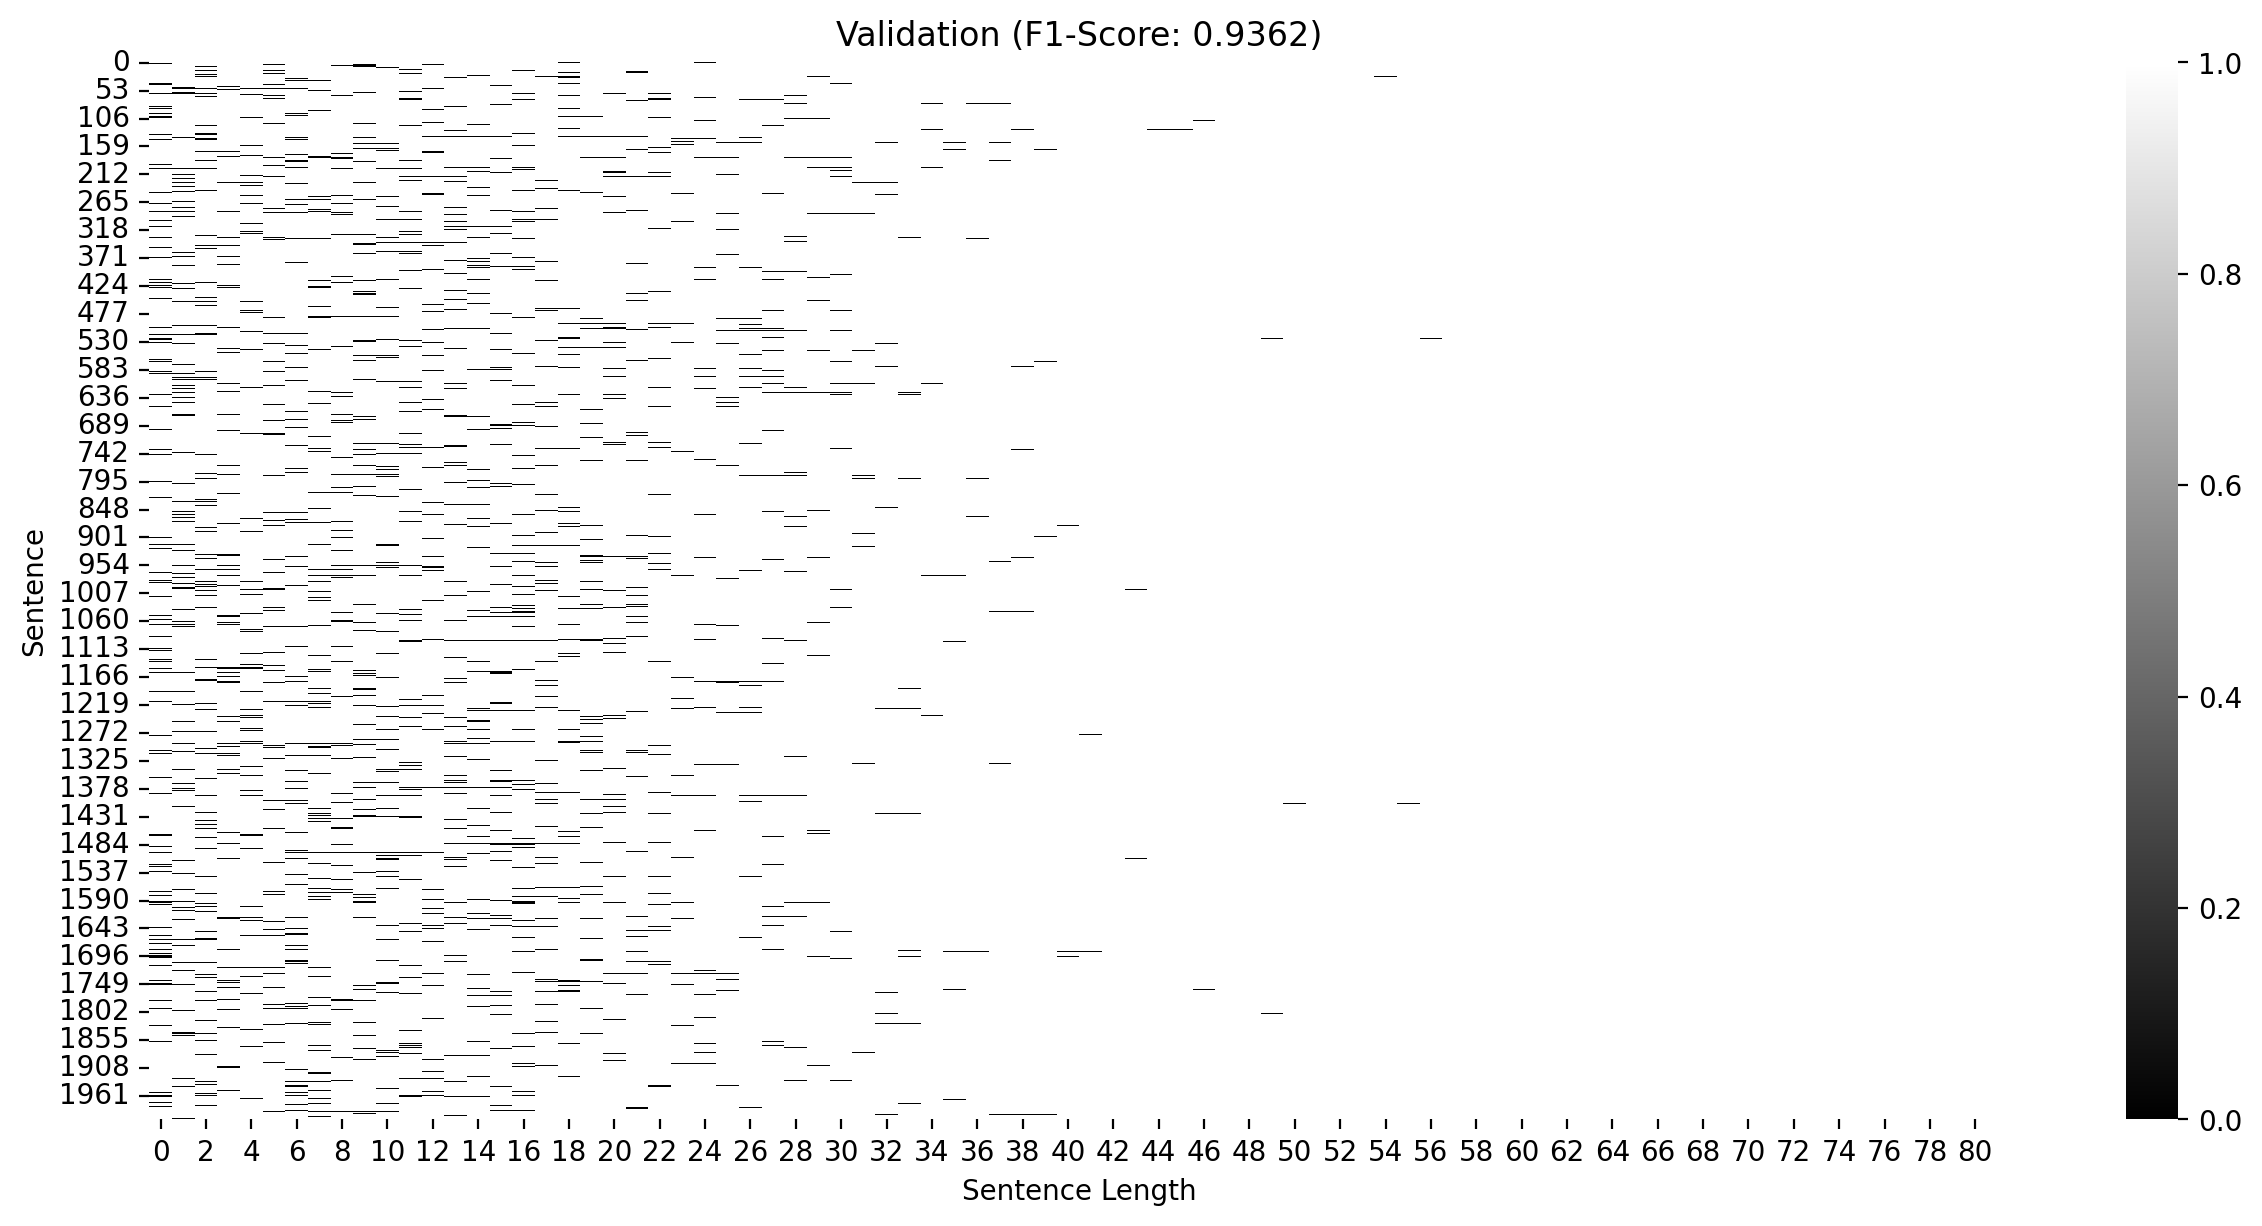

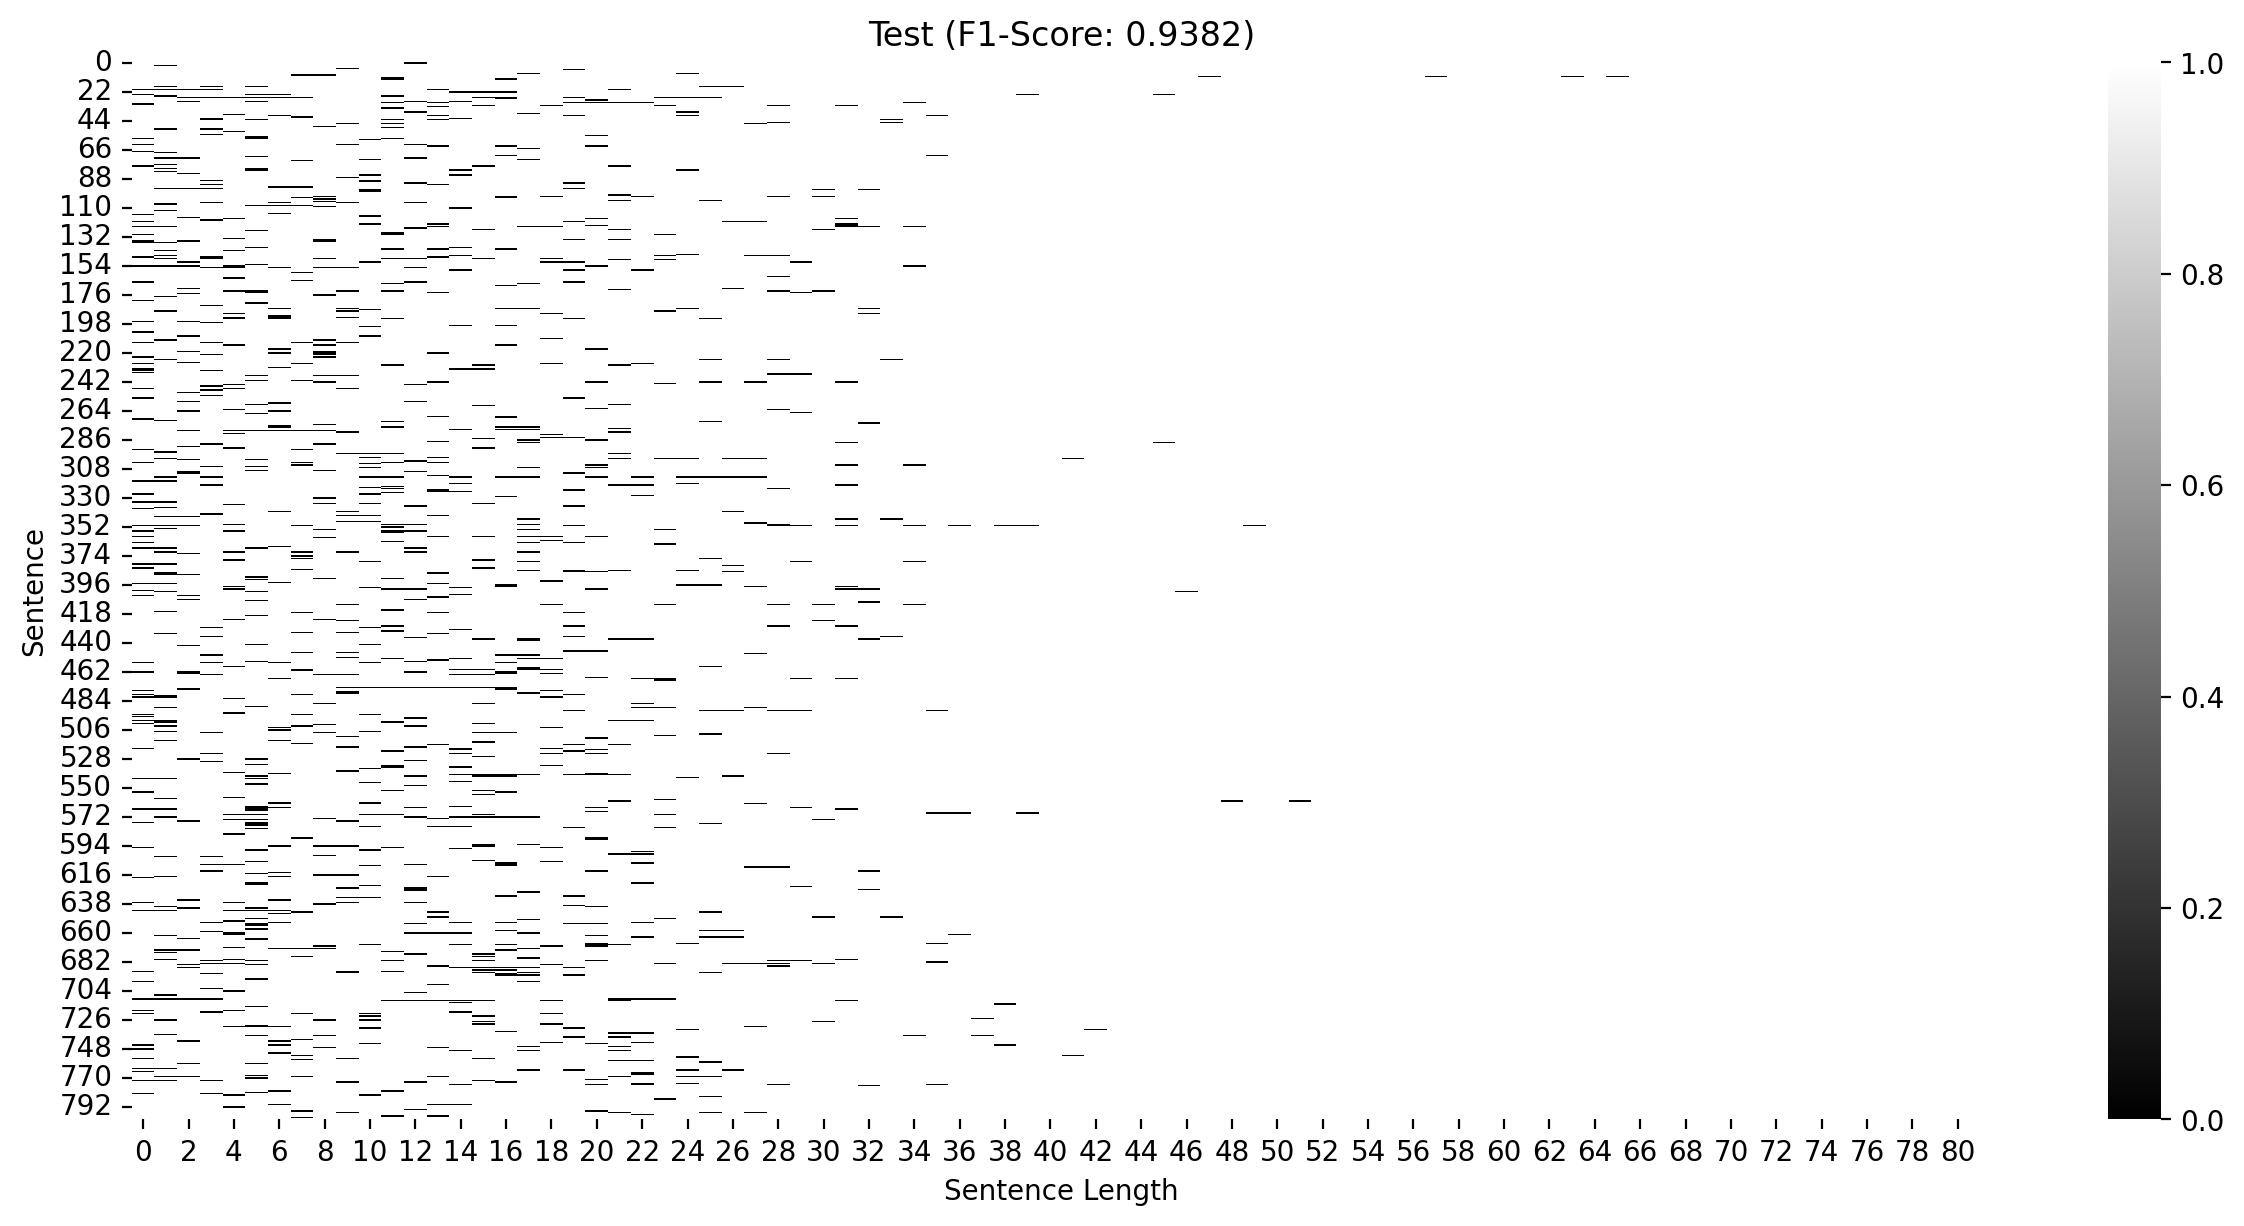

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


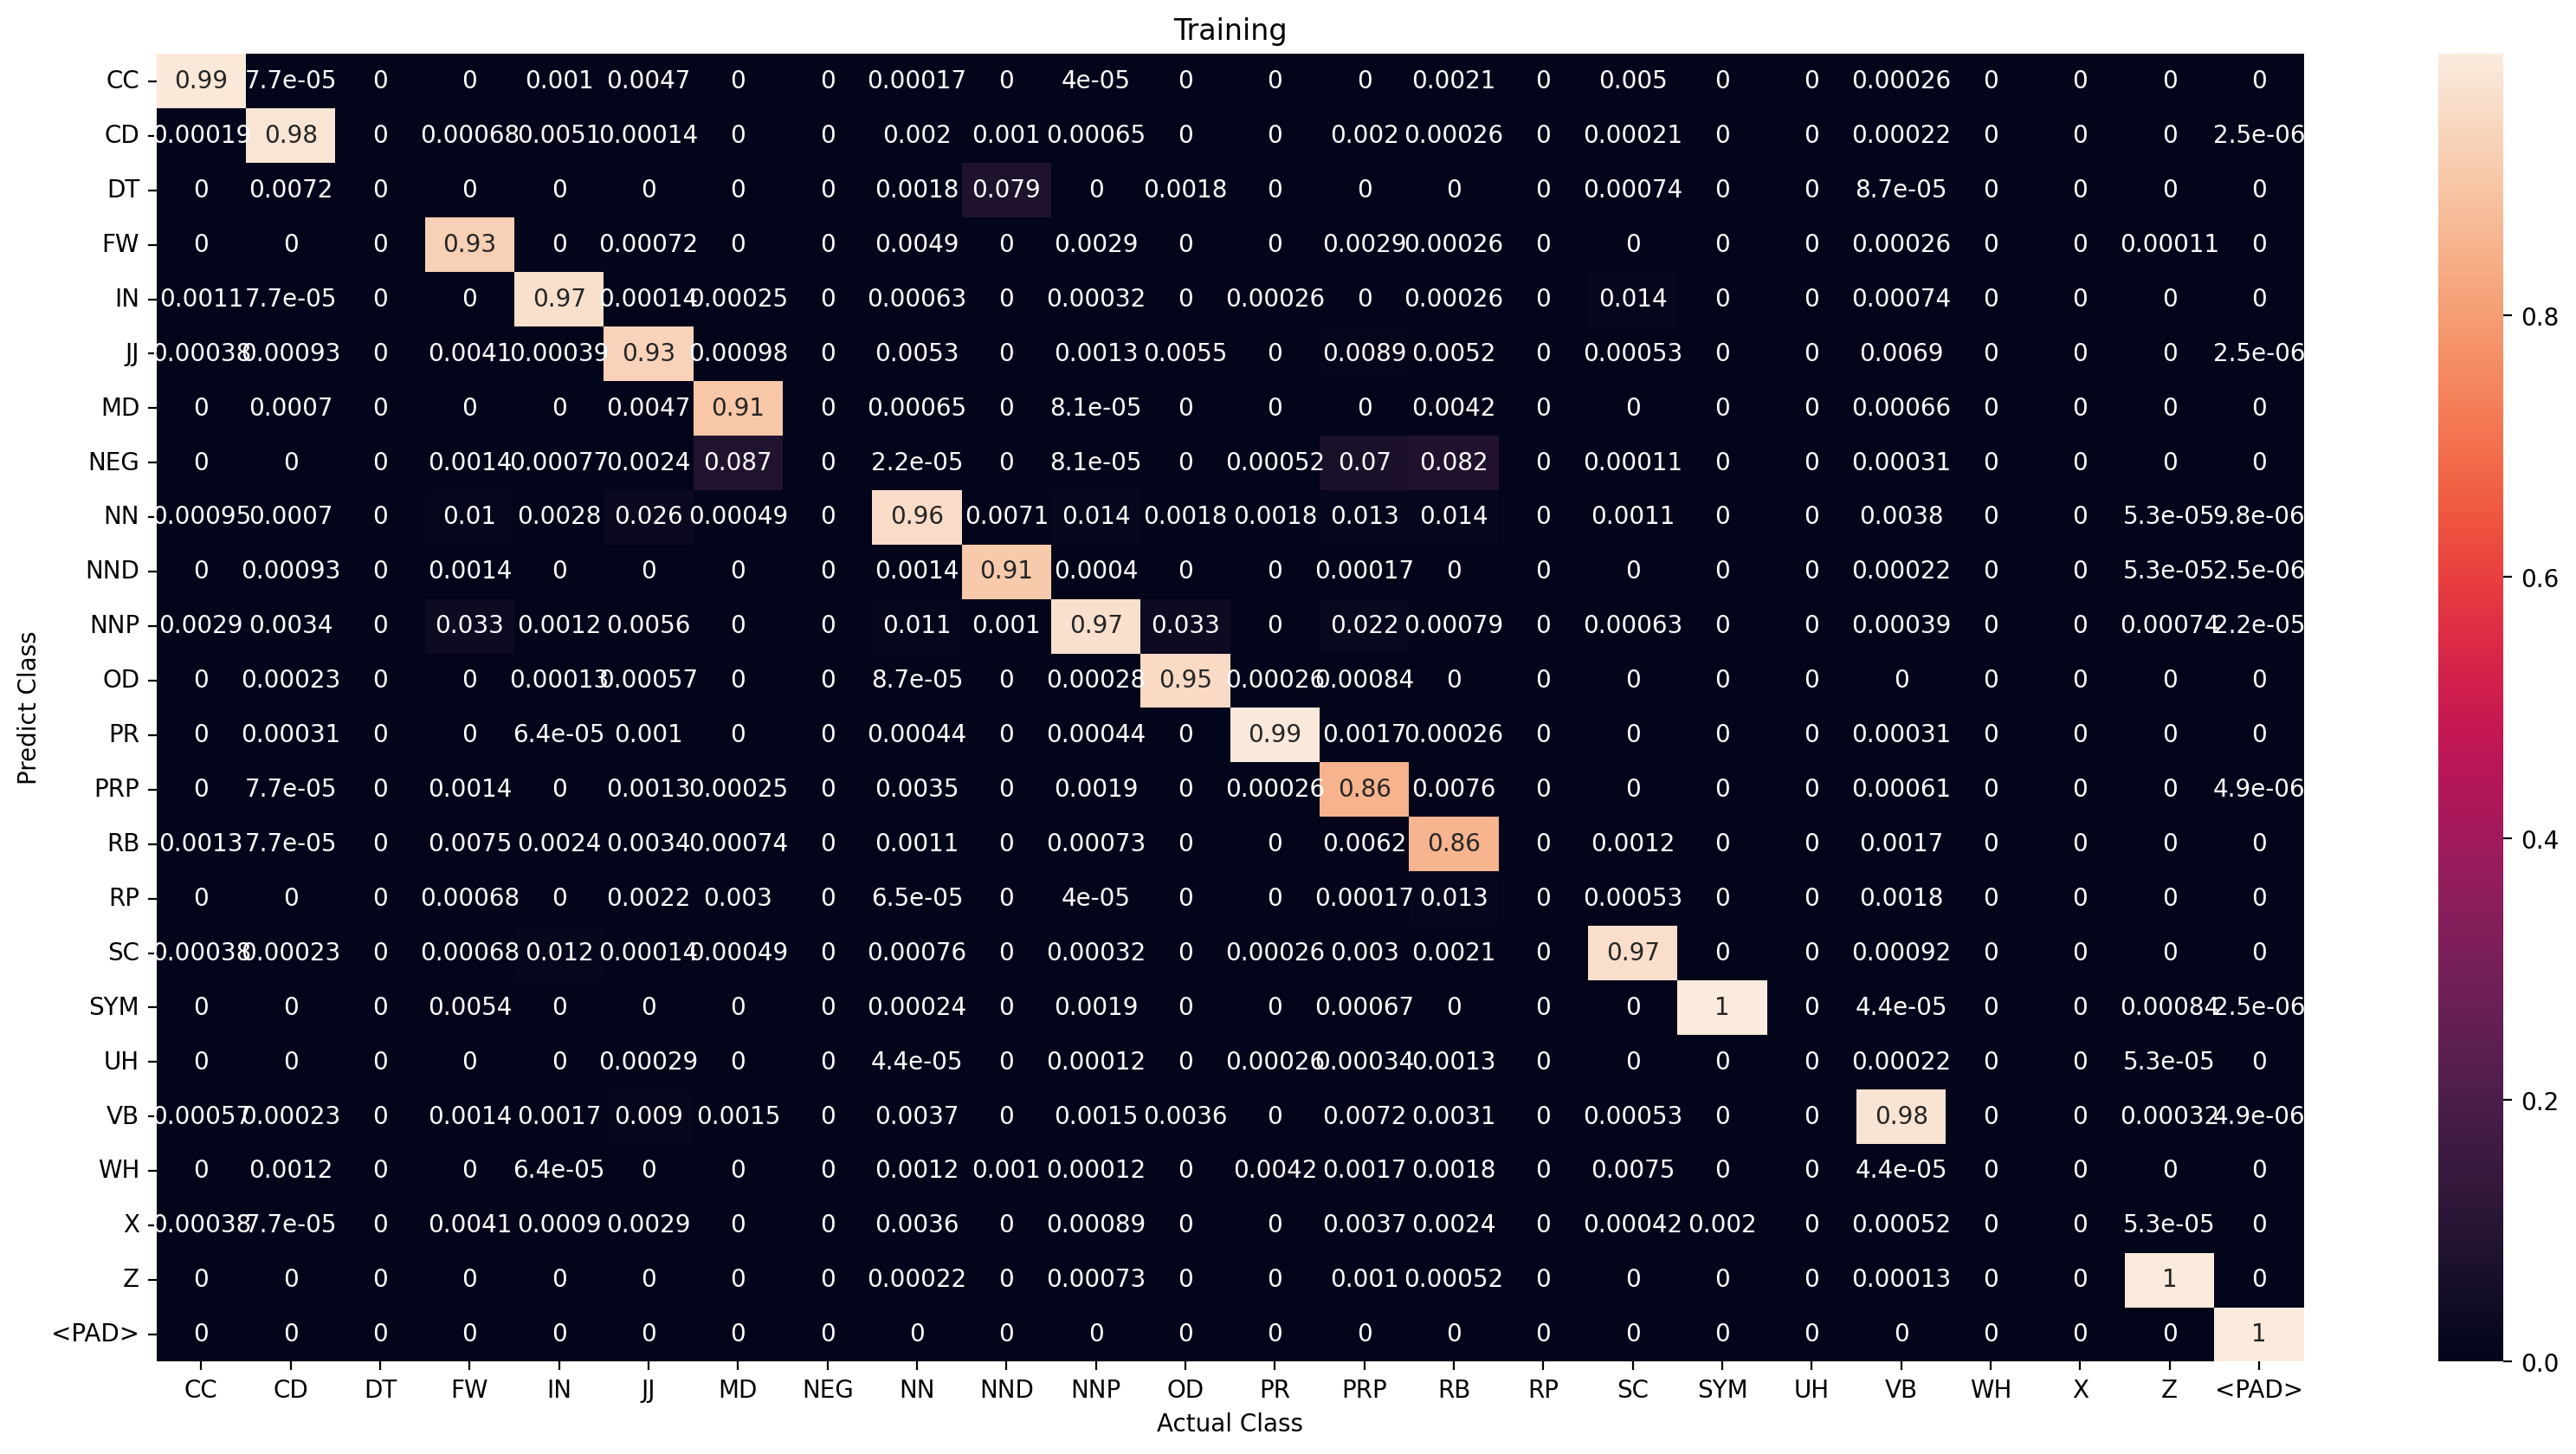

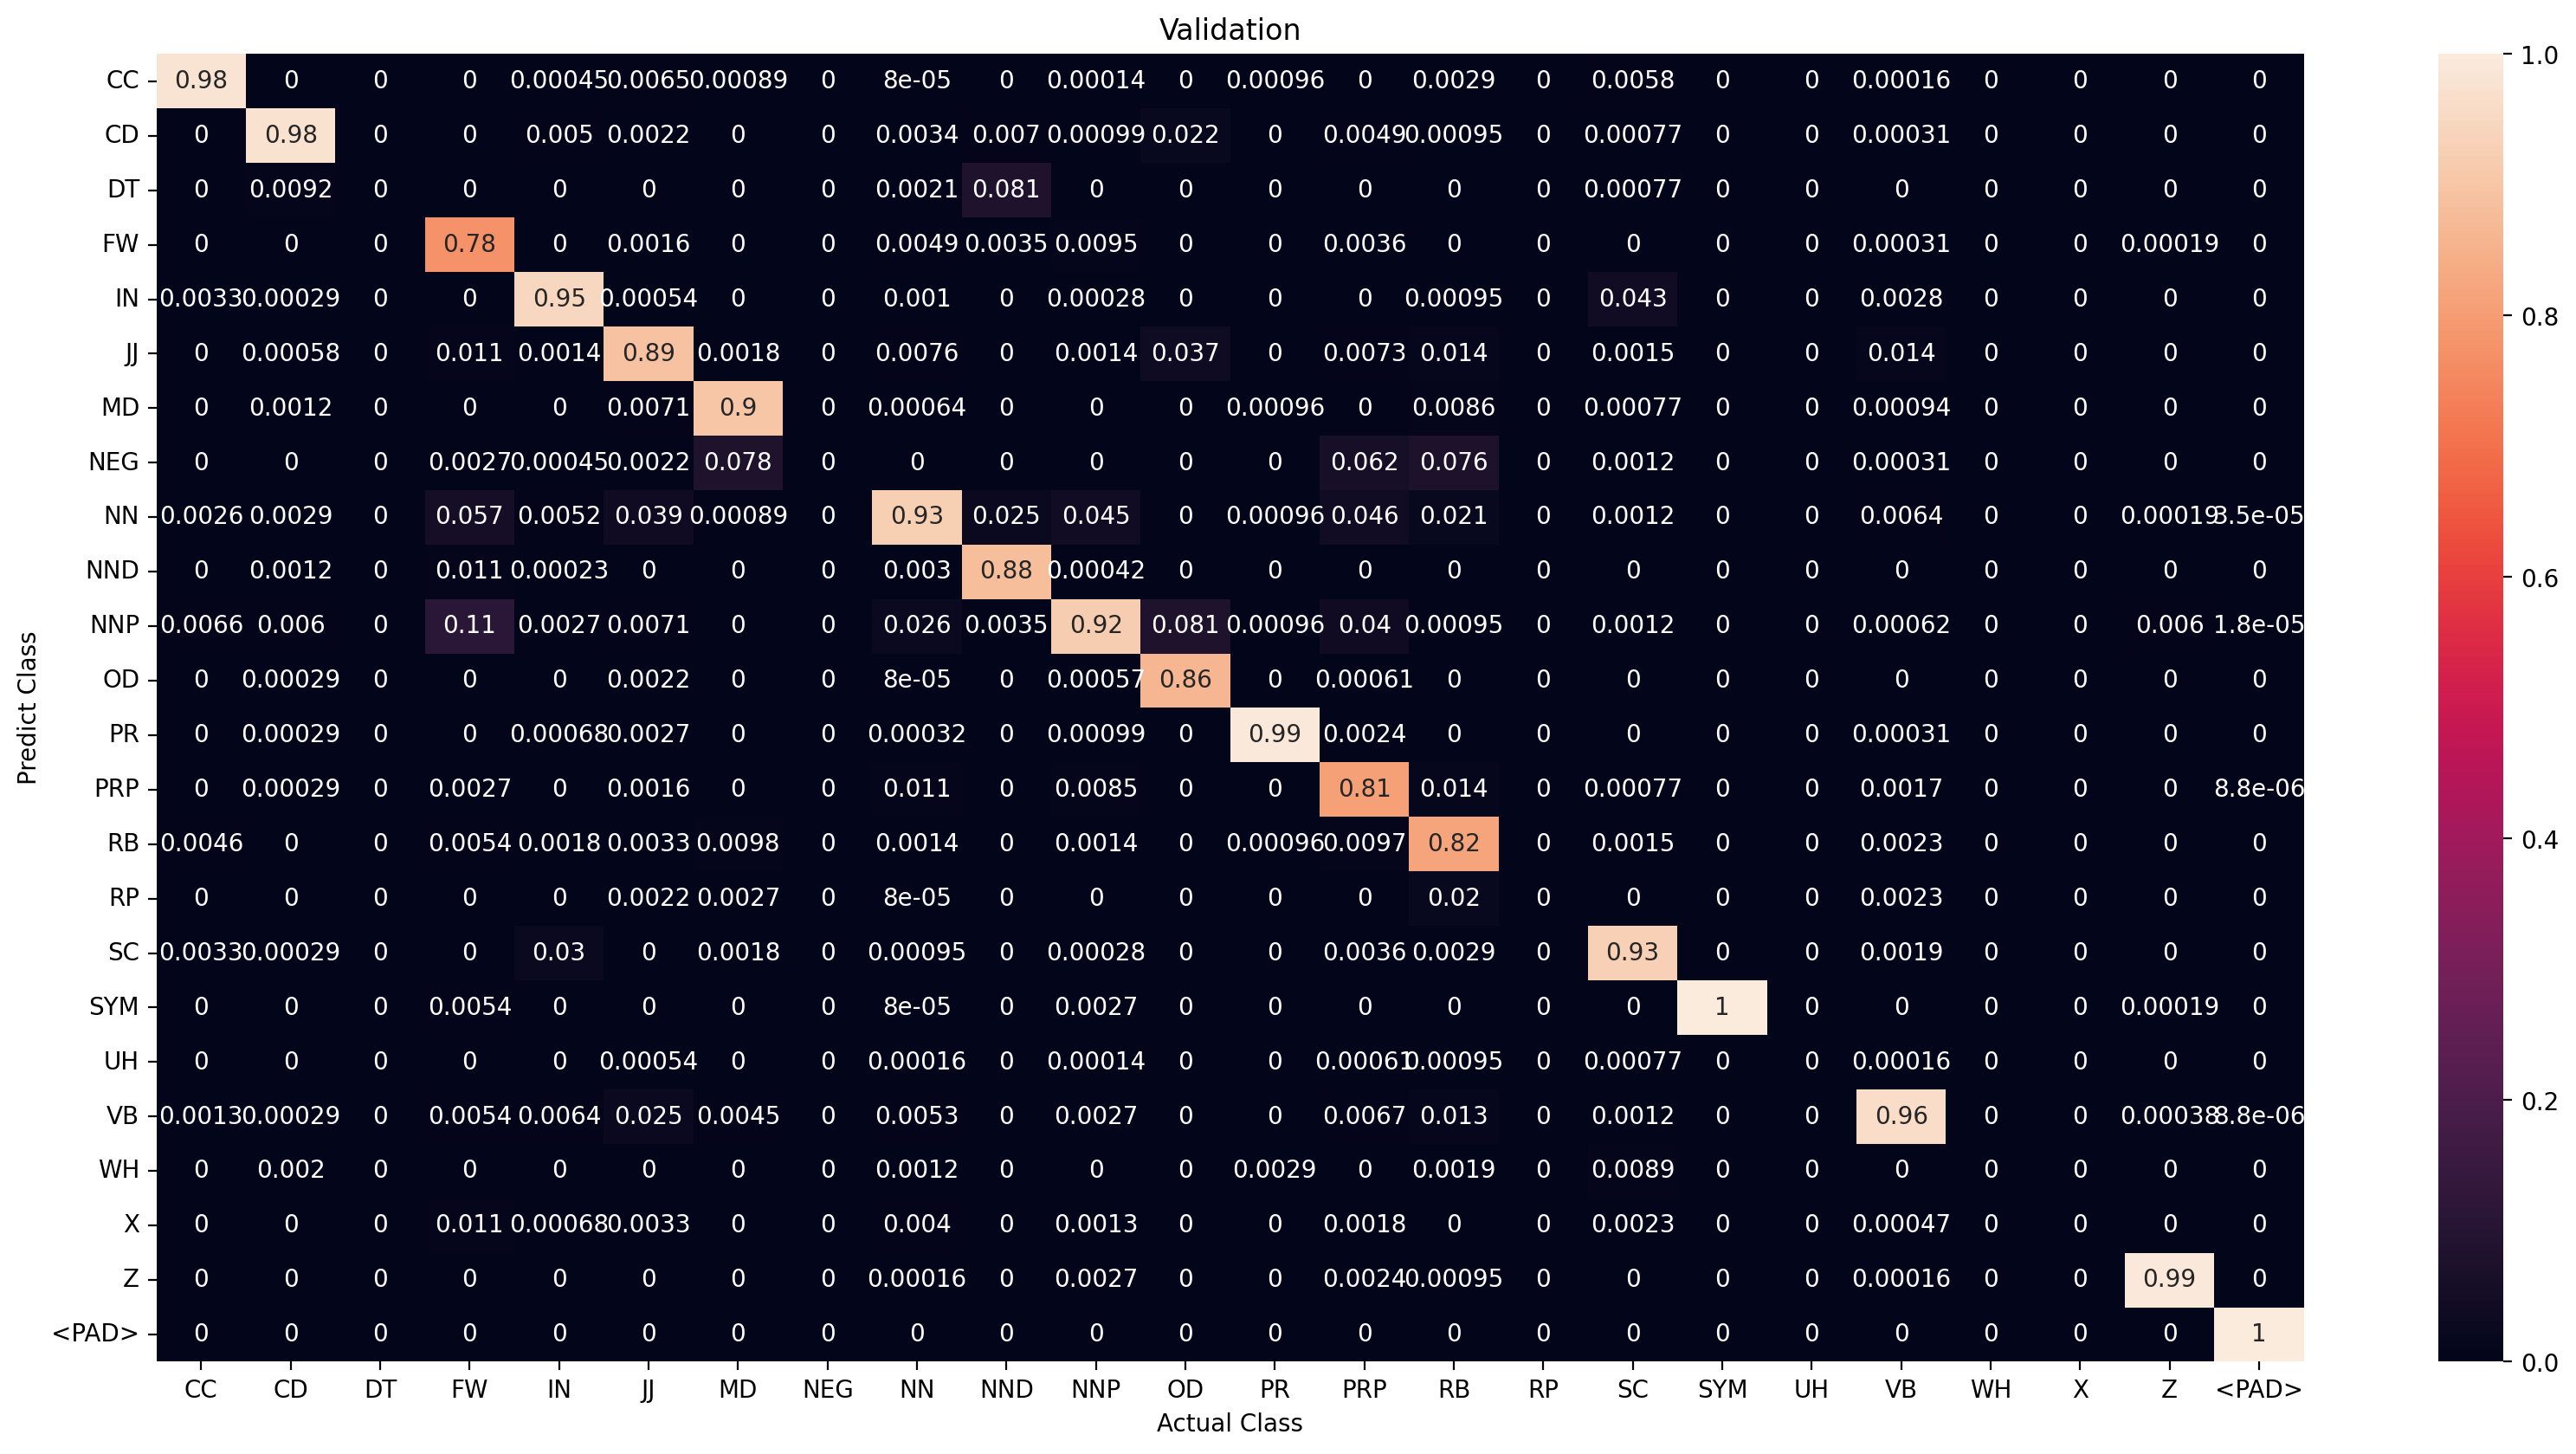

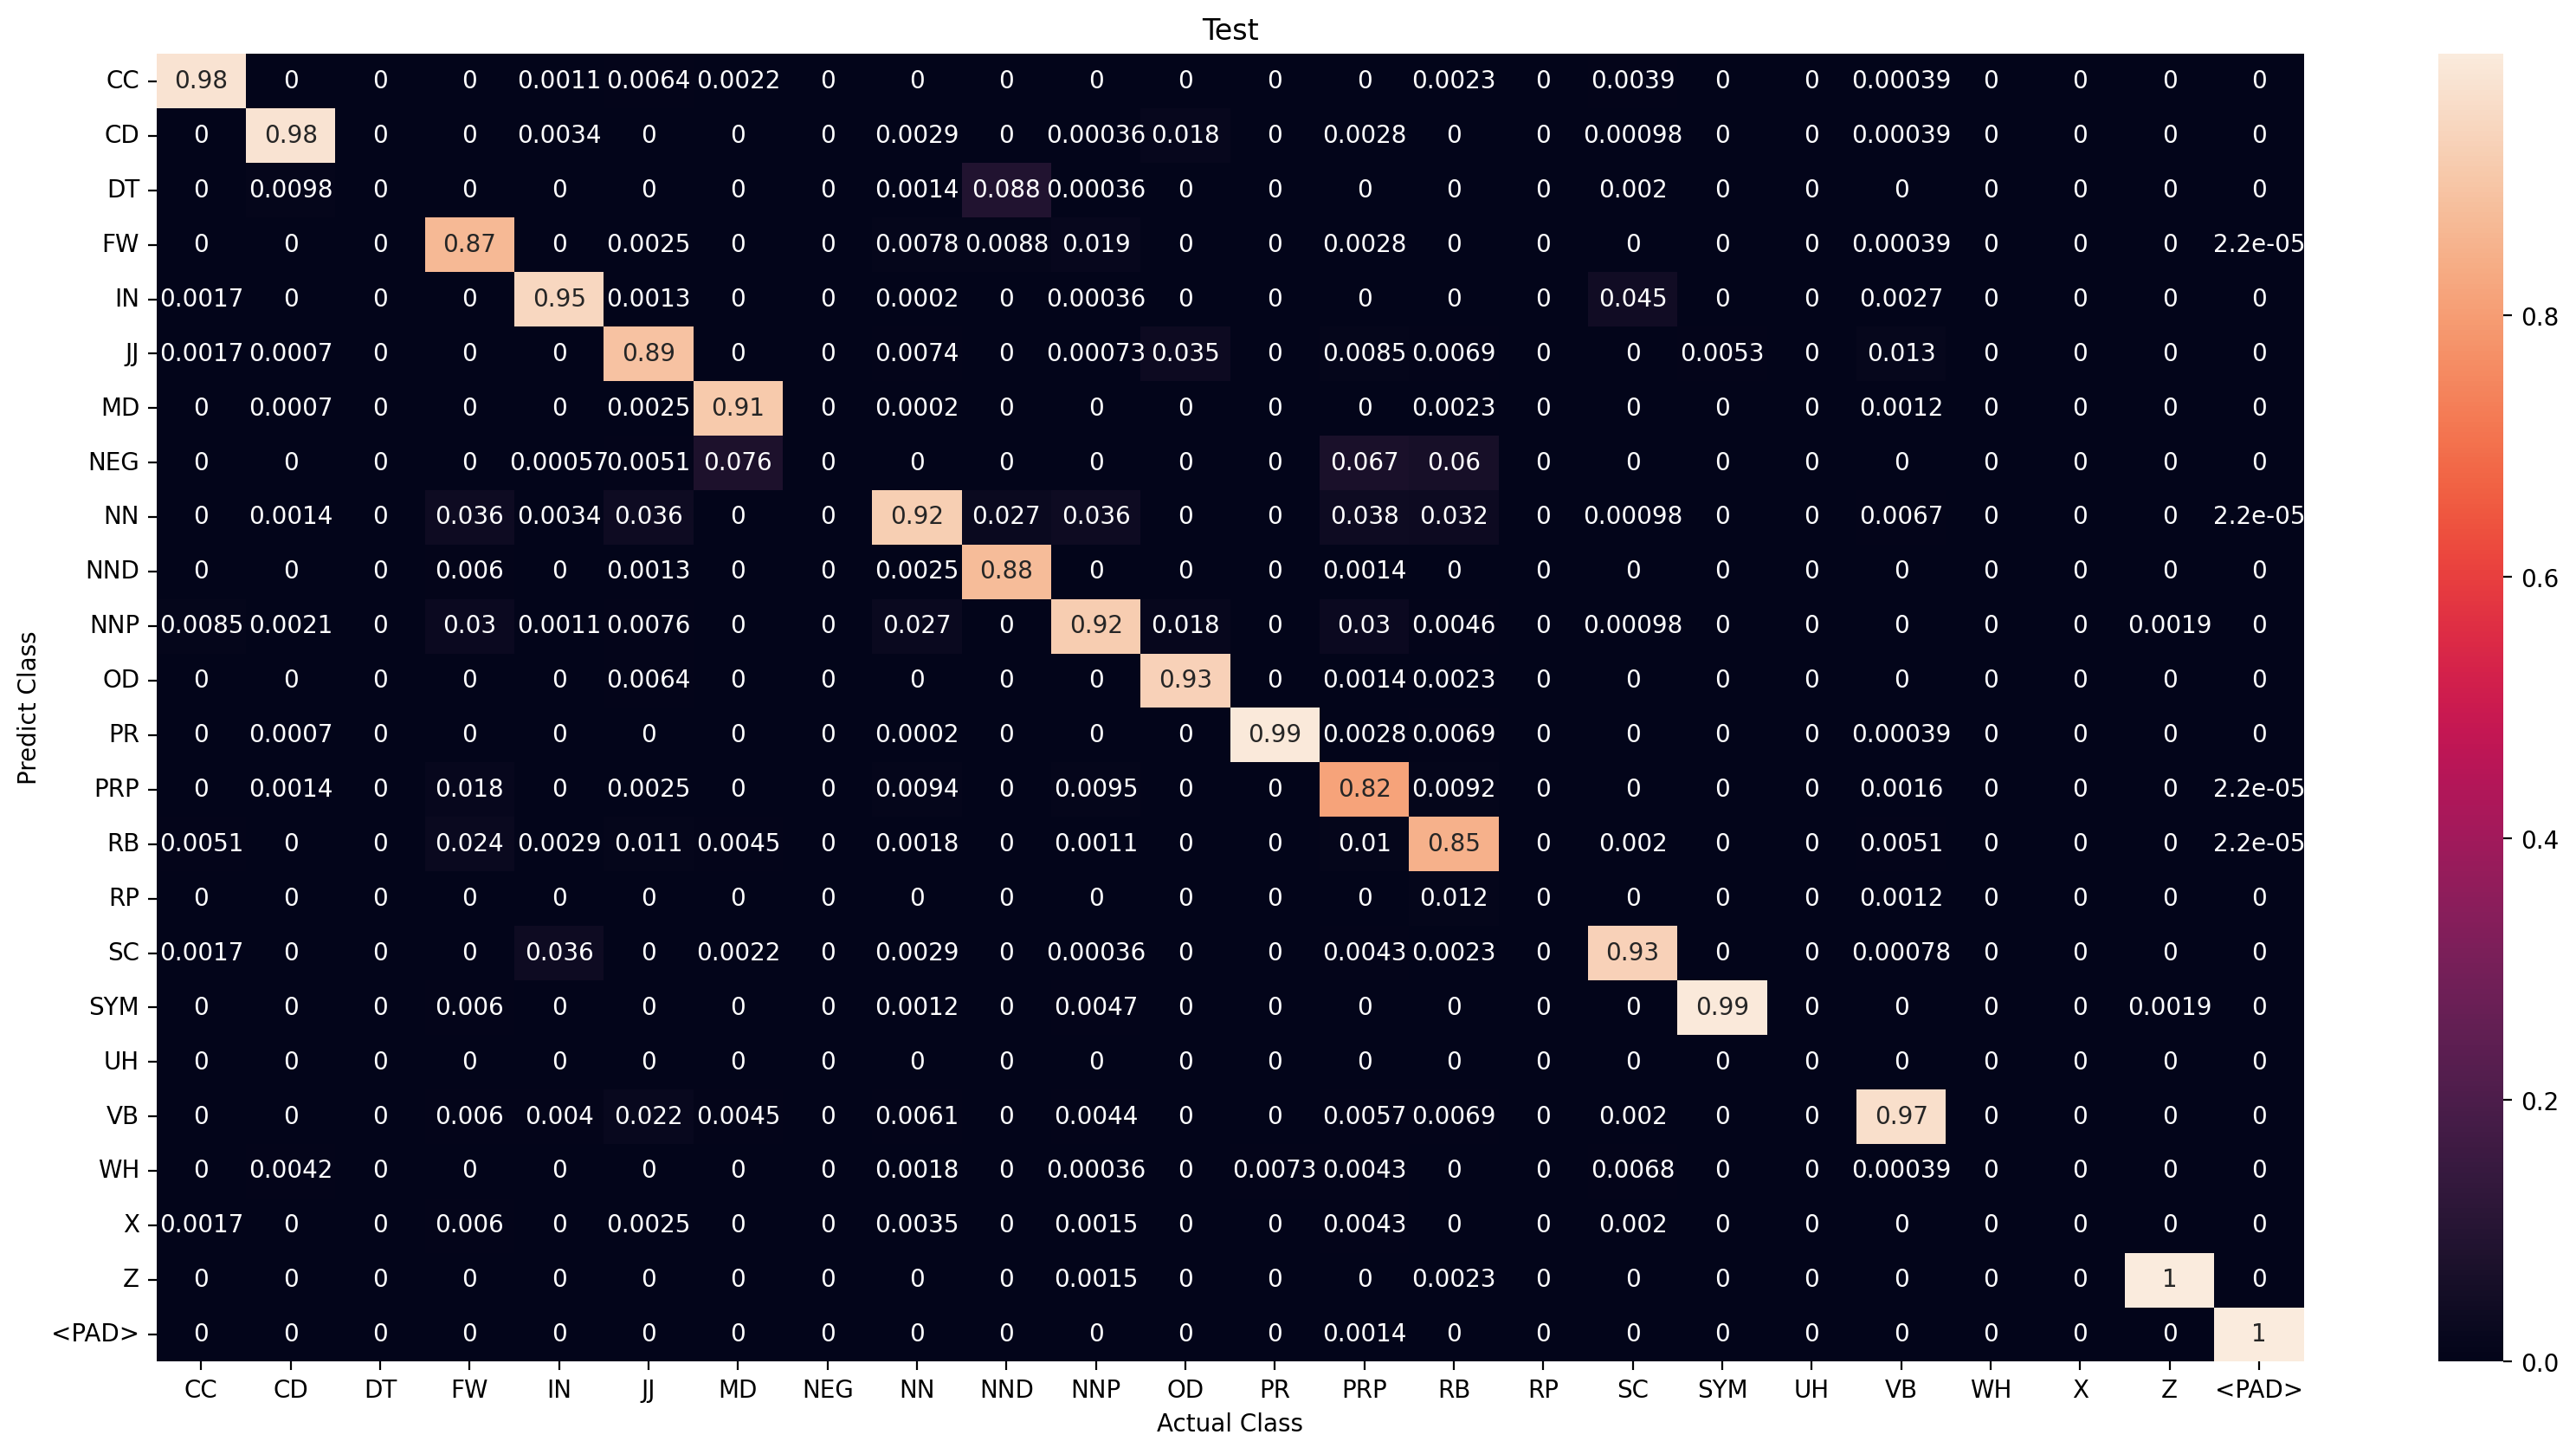

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5216       | CC    : 120      |
| CD    : 12904  | CD    : 12693      | CD    : 211      |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1367       | FW    : 330      |
| IN    : 15290  | IN    : 15096      | IN    : 194      |
| JJ    : 7049   | JJ    : 6506       | JJ    : 543      |
| MD    : 3783   | MD    : 3678       | MD    : 105      |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 43917      | NN    : 852      |
| NND   : 998    | NND   : 901        | NND   : 97       |
| NNP   : 24884  | NNP   : 24034      | NNP   : 850      |
| OD    : 550    | OD    : 524        | OD    : 26       |
| PR    : 3878   | PR    : 3817       | PR    : 61       |
| PRP   : 5355   | PRP   : 5090       | PRP   : 265      |
| RB    : 3517   | RB    : 3278       | RB    : 239      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 10194
Wrong prediction            : 1740
Percentage correct oov pred : 85.41980894922071

Validation
Number OOV token            : 3261
Correct prediction          : 2363
Wrong prediction            : 898
Percentage correct oov pred : 72.46243483593989

Test
Number OOV token            : 1367
Correct prediction          : 977
Wrong prediction            : 390
Percentage correct oov pred : 71.47037307973665



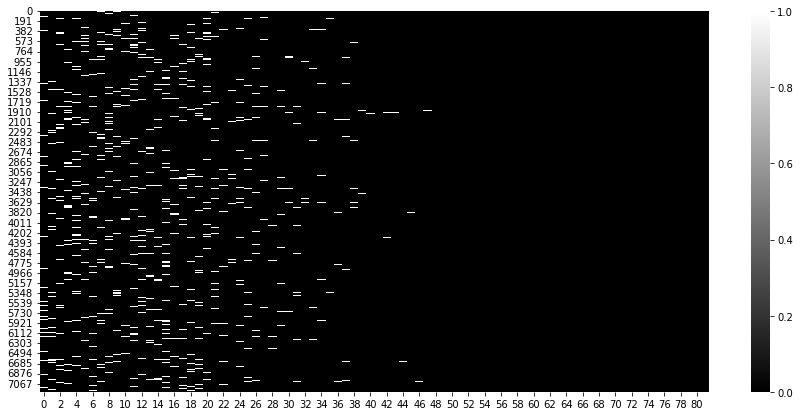

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

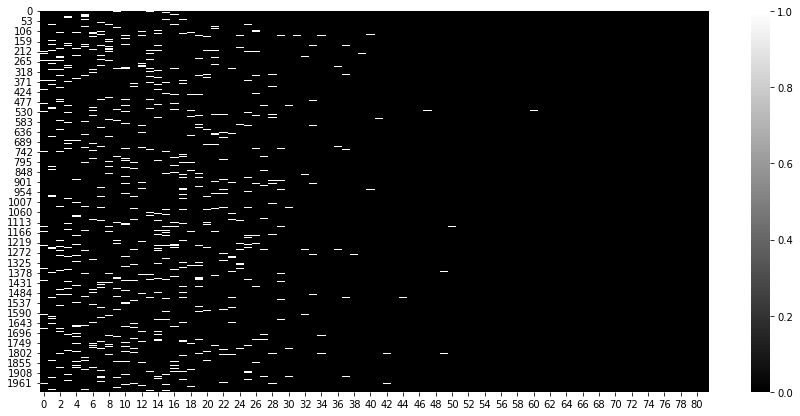

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

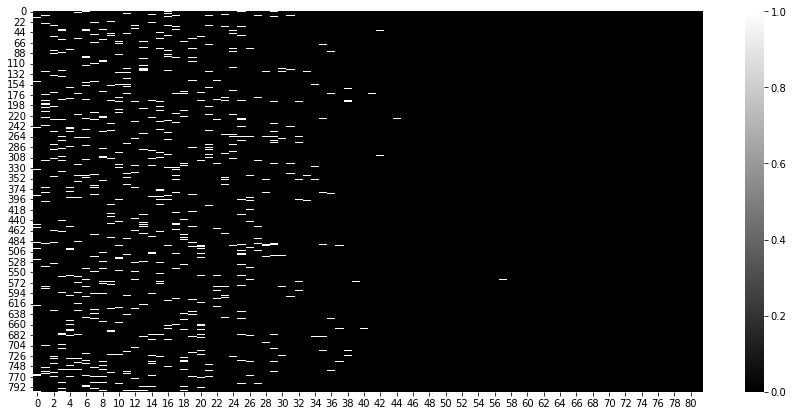

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);